In [17]:
!wget --no-check-certificate \https://github.com/fachris007/tubes-baru/raw/main/DatasetTubes.zip \
    -O /tmp/Dataset.zip

--2021-12-29 13:12:07--  https://github.com/fachris007/tubes-baru/raw/main/DatasetTubes.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fachris007/tubes-baru/main/DatasetTubes.zip [following]
--2021-12-29 13:12:07--  https://raw.githubusercontent.com/fachris007/tubes-baru/main/DatasetTubes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93990564 (90M) [application/zip]
Saving to: ‘/tmp/Dataset.zip’

/tmp/Dataset.zip    100%[===================>]  89.64M   189MB/s    in 0.5s    

2021-12-29 13:12:08 (189 MB/s) - ‘/tmp/Dataset.zip’ saved [93990564/93990564]



In [18]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
# Extract file zip dataset

import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [20]:
base_dir = '/tmp/DatasetTubes'
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')

In [21]:
Daisies_train_path = train_dir + '/Daisies'
Tulip_train_path = train_dir + '/Tulips'
Daisies_val_path = val_dir + '/Daisies'
Tulips_val_path = val_dir + '/Tulip'

Daisies_len_train = len(os.listdir(Daisies_train_path))
Tulip_len_train = len(os.listdir(Tulip_train_path))
Daisies_len_val = len(os.listdir(Daisies_val_path))
Tulips_len_val = len(os.listdir(Tulips_val_path))

print("jumlah dataset Training : ", Daisies_len_train + Tulip_len_train)
print("jumlah dataset validasi : ", Daisies_len_val + Tulips_len_val)
print("\n\n")
print("jumlah train kelas Daisies : ", Daisies_len_train)
print("jumlah train kelas Tulip : ", Tulip_len_train)
print("jumlah validasi kelas Daisies : ", Daisies_len_val)
print("jumlah validasi kelas Tulip : ", Tulips_len_val)

jumlah dataset Training :  124
jumlah dataset validasi :  30



jumlah train kelas Daisies :  68
jumlah train kelas Tulip :  56
jumlah validasi kelas Daisies :  15
jumlah validasi kelas Tulip :  15


In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Augmentasi Dataset**

In [23]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 124 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


# **Augmentasi Model dan Fit Model**

In [24]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
'''
definisikan dan setting callback untuk :
1. memantau performa model
2. melakukan save model terbaik menggunakan model checkpoint
3. memberhentikan pelatihan ketika tidak memnuhi syarat dalam parameter earlystopping
'''

callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [26]:
'''
definisikan pretrained model yang ingin digunakan
'''

VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))

In [27]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

VGG16_base.trainable = False

In [28]:
'''
mendefinisikan layer pada bagian fully connected layer
'''

print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [29]:
VGG16_model = Model(VGG16_base.input, output)

VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [30]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [31]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch = 6,  # images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps = 1,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.9026 - accuracy: 0.6442
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5
6/6 [==============================] - 11s 2s/step - loss: 0.9026 - accuracy: 0.6442 - val_loss: 0.6061 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.7500
Epoch 00002: val_accuracy improved from 0.50000 to 0.55000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5
6/6 [==============================] - 9s 2s/step - loss: 0.5537 - accuracy: 0.7500 - val_loss: 0.5486 - val_accuracy: 0.5500
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.7500
Epoch 00003: val_accuracy improved from 0.55000 to 0.65000, saving model to /content/gdrive/MyDrive/Colab

# **Model Evaluasi**

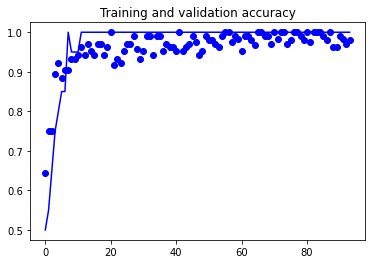

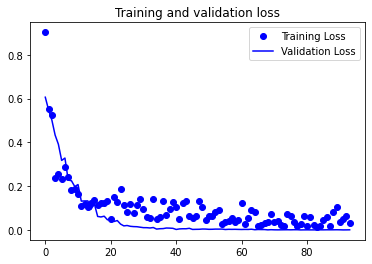

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()